# A Lightweight Concept Drift Detection and Adaptation Framework for IoT Data Streams
This is the code for the paper entitled "**A Lightweight Concept Drift Detection and Adaptation Framework for IoT Data Streams**" accepted in IEEE Internet of Things Magazine.  
Authors: Li Yang (lyang339@uwo.ca) and Abdallah Shami (Abdallah.Shami@uwo.ca)  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

**Notebook 3: Proposed Optimized Adaptive and Sliding Windowing (OASW) method for concept drift detection and adaptation**  
Aims:  
&nbsp; 1): Develop a drift detection and adaptation method to handle concept drift   
&nbsp; 2): Obtain the optimized drift model using hyperparameter optimization techniques  

## Import libraries

In [3]:
 from google.colab import drive
 drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install river==0.19.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 12.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from river import metrics
from river import stream
import matplotlib.pyplot as plt
import seaborn as sns
import time

## Read the CIC dataset

In [7]:
df = pd.read_csv("/content/drive/MyDrive/SEA_concept.csv")

In [8]:
df

,X1,X2,X3,label
0,6.677259,5.152133,2.982455,0
1,9.874437,8.817701,4.786266,1
2,7.118725,2.990575,1.964403,0
3,6.128244,8.449696,2.604408,1
4,7.592623,0.859845,5.763160,0
...,...,...,...,...
59995,4.760386,7.501301,5.680291,1
59996,7.873042,7.951943,1.213854,1
59997,8.430418,9.531408,1.034550,0
59998,6.438425,8.759620,6.009597,1


## Train-test split
10% training set, and 90% test set

In [9]:
y = df['label']
X = df.drop(['label'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.1, test_size = 0.9, shuffle=False, random_state = 0)

## Offline learning: LightGBM

In [10]:
!pip install memory-profiler

In [11]:
%%time
import memory_profiler as mem_profile
m1 = mem_profile.memory_usage()
print('Memory (Before): ' + str(m1[0]) + ' MB' )

classifier = lgb.LGBMClassifier()
# classifier = joblib.load('Optimized_lightGBM.pkl')
classifier.fit(X_train,y_train)
predictions = classifier.predict(X_test)
print("Accuracy: "+str(accuracy_score(y_test,predictions)))
print("Precision: "+str(precision_score(y_test,predictions)))
print("Recall: "+str(recall_score(y_test,predictions)))
print("F1-Score: "+str(f1_score(y_test,predictions)))


m2 = mem_profile.memory_usage()
print('Memory (After) : ' + str(m2[0]) + ' MB')
print('Memory Consumption : ' + str(m2[0]-m1[0]) + ' MB')

Memory (Before): 237.33984375 MB
[LightGBM] [Info] Number of positive: 3880, number of negative: 2120
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.646667 -> initscore=0.604419
[LightGBM] [Info] Start training from score 0.604419
Accuracy: 0.8422407407407407
Precision: 0.841869797456685
Recall: 0.920352146075409
F1-Score: 0.8793633261112763
Memory (After) : 243.62109375 MB
Memory Consumption : 6.28125 MB
CPU times: user 604 ms, sys: 11.2 ms, total: 616 ms
Wall time: 910 ms


# OASW method Development

## Define the OASW method

In [12]:
import time
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

# a: warining threshold, b: drift threshold, win1: sliding window size, win2: adaptive window max size
def oasw_bo(params):

    a=abs(float(params['a']))
    b=abs(float(params['b']))
    win1=int(params['win1'])
    win2=int(params['win2'])

    i=0
    yt = []
    yp = []
    x_new=[]
    y_new=[]
    dr=[0]
    d=0
    f=0
    tt=0
    th=0
    xt=[]

    metric = metrics.Accuracy()

    classifier = lgb.LGBMClassifier() # Train the initial LightGBM model
    classifier.fit(X_train,y_train)

    for xi, yi in stream.iter_pandas(X_test, y_test):

        xi2=np.array(list(xi.values()))
        y_pred = classifier.predict(xi2.reshape(1, -1))      # make a prediction
        metric = metric.update(yi, int(y_pred[0]))  # update the metric

        # Store the y_test, y_pred, and x_test
        yt.append(yi)
        yp.append(y_pred)
        xt.append(xi2)

        # Monitor the accuracy changes in the sliding window
        if i>2*win1:
            acc1=accuracy_score(yt[i-win1:],yp[i-win1:]) # Current window accuracy
            acc2=accuracy_score(yt[i-2*win1:i-win1],yp[i-2*win1:i-win1]) # Last window accuracy
            if (d==0)&(acc1<a*acc2): # If the window accuracy drops to the warning level
                x_new.append(xi2)
                y_new.append(yi)
                d=1
            if d==1: # In the warning level
                tt=len(y_new)
                if acc1<b*acc2: # If the window accuracy drops to the drift level
                    dr.append(i)# Record the drift start point
                    f=i
                    if tt<win1: # if enough new concept samples are collected
                        classifier.fit(xt[i-win1:],yt[i-win1:])
                    else:
                        classifier.fit(x_new,y_new)
                    d=2
                elif (acc1>a*acc2)|(tt==win2): # If the window accuracy increases back to the normal level (false alarm)
                    x_new=[]
                    y_new=[]
                    d=0
                else:
                    x_new.append(xi2)
                    y_new.append(yi)
            if d==2: # In the drift level
                tt=len(y_new)
                acc3=accuracy_score(yt[f:f+win1],yp[f:f+win1])
                x_new.append(xi2)
                y_new.append(yi)
                if tt>=win1:
                    if (acc1<a*acc3): # When new concept accuracy drops to the warning level
                        if th==0:
                            classifier.fit(x_new,y_new) # Retrain the classifier on all the newly collected samples to obtain a robust classifier
                            th=1
                    if (th==1)&(tt==win2): # When sufficient new concept samples are collected
                        classifier.fit(x_new,y_new) #obtain a robust classifier
                        x_new=[]
                        y_new=[]
                        d=0 # Go back to the normal state for next potential drift detection
                        th=0

        i=i+1
    score=metric.get()
    print(str(a)+" "+str(b)+" "+str(win1)+" "+str(win2)+" "+str(score)) # Output the hyperparameter values and corresponding accuracy
    return {'loss': -score, 'status': STATUS_OK }


## Hyperparameter optimization by BO-TPE

In [13]:

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
space = {
    'a': hp.quniform('a', 0.95, 0.99, 0.001),
    'b': hp.quniform('b', 0.90, 0.98, 0.001),
    'win1': hp.quniform('win1', 200, 1000, 50),
    'win2': hp.quniform('win2', 1000, 5000, 100),
}

t1=time.time()
best = fmin(fn=oasw_bo,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print(t2-t1)

[LightGBM] [Info] Number of positive: 3880, number of negative: 2120
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.646667 -> initscore=0.604419
[LightGBM] [Info] Start training from score 0.604419
[LightGBM] [Info] Number of positive: 644, number of negative: 357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1001, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.643357 -> initscore=0.589963
[LightGBM] [Info] Start training from score 0.589963
[LightGBM] [Info] Number of 

## Hyperparameter optimization by PSO

In [14]:
def oasw(a=0.99, b=0.95, win1=200, win2=1000):
    a = round(a, 3)
    b = round(b, 3)
    win1 = round(win1)
    win2 = round(win2)

    i=0
    yt = []
    yp = []
    x_new=[]
    y_new=[]
    dr=[0]
    d=0 #state
    f=0
    tt=0
    th=0
    xt=[]

    metric = metrics.Accuracy()

    classifier = lgb.LGBMClassifier() # Train the initial LightGBM model
    classifier.fit(X_train,y_train)

    for xi, yi in stream.iter_pandas(X_test, y_test):

        xi2=np.array(list(xi.values()))
        y_pred = classifier.predict(xi2.reshape(1, -1))      # make a prediction
        metric = metric.update(yi, int(y_pred[0]))  # update the metric

        # Store the y_test, y_pred, and x_test
        yt.append(yi)
        yp.append(y_pred)
        xt.append(xi2)

        # Monitor the accuracy changes in the sliding window
        if i>2*win1:
            acc1=accuracy_score(yt[i-win1:],yp[i-win1:]) # Current window accuracy
            acc2=accuracy_score(yt[i-2*win1:i-win1],yp[i-2*win1:i-win1]) # Last window accuracy
            if (d==0)&(acc1<a*acc2): # If the window accuracy drops to the warning level
                x_new.append(xi2)
                y_new.append(yi)
                d=1
            if d==1: # In the warning level
                tt=len(y_new)
                if acc1<b*acc2: # If the window accuracy drops to the drift level
                    dr.append(i)# Record the drift start point
                    f=i
                    if tt<win1: # if enough new concept samples are collected
                        classifier.fit(xt[i-win1:],yt[i-win1:])
                    else:
                        classifier.fit(x_new,y_new)
                    d=2
                elif (acc1>a*acc2)|(tt==win2): # If the window accuracy increases back to the normal level (false alarm)
                    x_new=[]
                    y_new=[]
                    d=0
                else:
                    x_new.append(xi2)
                    y_new.append(yi)
            if d==2: # In the drift level
                tt=len(y_new)
                acc3=accuracy_score(yt[f:f+win1],yp[f:f+win1])
                x_new.append(xi2)
                y_new.append(yi)
                if tt>=win1:
                    if (acc1<a*acc3): # When new concept accuracy drops to the warning level
                        if th==0:
                            classifier.fit(x_new,y_new) # Retrain the classifier on all the newly collected samples to obtain a robust classifier
                            th=1
                    if (th==1)&(tt==win2): # When sufficient new concept samples are collected
                        classifier.fit(x_new,y_new) #obtain a robust classifier
                        x_new=[]
                        y_new=[]
                        d=0 # Go back to the normal state for next potential drift detection
                        th=0

        i=i+1
    score=metric.get()
    print(str(a)+" "+str(b)+" "+str(win1)+" "+str(win2)+" "+str(score)) # Output the hyperparameter values and corresponding accuracy
    return score

In [15]:
!pip install Optunity

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 16.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for Optunity: filename=Optunity-1.1.1-py3-none-any.whl size=72029 sha256=94c6636d1e25f8a0e279a757afc1aaa803ac67c601c18a057cb58a8dcacbe24c
  Stored in directory: /root/.cache/pip/wheels/83/98/40/b9956c3386a045f035f9edbf894edd04713db92f29fb58a225
Successfully built Optunity


In [16]:
import optunity
import optunity.metrics

search = {
    'a': [0.95,0.99],
    'b': [0.90,0.98],
    'win1': [200,1000],
    'win2': [1000,5000],
         }

optimal_configuration, info, _ = optunity.maximize(oasw,
                                                  solver_name='particle swarm',
                                                  num_evals=10,
                                                   **search
                                                  )
print(optimal_configuration)
print("Accuracy:"+ str(info.optimum))

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

## Train the optimized OASW model with optimal hyperparameters
The accuracy change figure is also plotted

In [17]:
# Define OASW with a figure
def oasw_plot(a=0.99, b=0.95, win1=200, win2=1000):
    a = round(a, 3)
    b = round(b, 3)
    win1 = round(win1)
    win2 = round(win2)

    metric = metrics.Accuracy()
    metric2 = metrics.Accuracy()

    i = 0
    t = []
    yt = []
    yp = []
    m = []
    m2 = []
    x_new=[]
    y_new=[]
    dr=[0]
    d=0
    f=0
    tt=0
    th=0
    xt=[]

    classifier = lgb.LGBMClassifier() # Train the initial LightGBM model
    classifier.fit(X_train,y_train)

    classifier2 = lgb.LGBMClassifier() # Train an offline LightGBM model as a comparison model
    classifier2.fit(X_train,y_train)

    for xi, yi in stream.iter_pandas(X_test, y_test):

        xi2=np.array(list(xi.values()))
        y_pred = classifier.predict(xi2.reshape(1, -1))      # make a prediction
        metric = metric.update(yi, int(y_pred[0]))  # update the metric

        y_pred2= classifier2.predict(xi2.reshape(1, -1))
        metric2 = metric2.update(yi, int(y_pred2[0]))

        # Store the y_test, y_pred, x_test, and real-time accuracy
        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        m2.append(metric2.get()*100)
        xt.append(xi2)

        # Monitor the accuracy changes in the sliding window
        if i>2*win1:
            acc1=accuracy_score(yt[i-win1:],yp[i-win1:]) # Current window accuracy
            acc2=accuracy_score(yt[i-2*win1:i-win1],yp[i-2*win1:i-win1]) # Last window accuracy
            if (d==0)&(acc1<a*acc2): # If the window accuracy drops to the warning level
                x_new.append(xi2)
                y_new.append(yi)
                d=1
            if d==1: # In the warning level
                tt=len(y_new)
                if acc1<b*acc2: # If the window accuracy drops to the drift level
                    dr.append(i)# Record the drift start point
                    f=i
                    if tt<win1: # if enough new concept samples are collected
                        classifier.fit(xt[i-win1:],yt[i-win1:])
                    else:
                        classifier.fit(x_new,y_new)
                    d=2
                elif (acc1>a*acc2)|(tt==win2): # If the window accuracy increases back to the normal level (false alarm)
                    x_new=[]
                    y_new=[]
                    d=0
                else:
                    x_new.append(xi2)
                    y_new.append(yi)

            if d==2: # In the drift level
                tt=len(y_new)
                acc3=accuracy_score(yt[f:f+win1],yp[f:f+win1])
                x_new.append(xi2)
                y_new.append(yi)
                if tt>=win1:
                    if (acc1<a*acc3): # When new concept accuracy drops to the warning level
                        if th==0:
                            classifier.fit(x_new,y_new) # Retrain the classifier on all the newly collected samples to obtain a robust classifier
                            th=1
                    if (th==1)&(tt==win2): # When sufficient new concept samples are collected
                        classifier.fit(x_new,y_new) #obtain a robust classifier
                        x_new=[]
                        y_new=[]
                        d=0 # Go back to the normal state for next potential drift detection
                        th=0

        i=i+1

    # Plot the accuracy change figure
    plt.rcParams.update({'font.size': 35})
    plt.ion()
    plt.figure(1,figsize=(24,15))
    sns.set_style("darkgrid")
    plt.clf()
    plt.plot(t,m,'-b',label='OASW+LightGBM, Avg Accuracy: %.2f%%'%(metric.get()*100))
    plt.plot(t,m2,'red',label='Offline LightGBM, Avg Avg Accuracy: %.2f%%'%(metric2.get()*100))

    #Plot the drift points
    for i in range(len(dr)):
        if i!=0:
            plt.scatter(dr[i],m[dr[i]],s=200,c='r')

    plt.legend(loc='best')
    plt.ylim(70, 101)
    plt.title('SEA dataset', fontsize=40)
    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy(%)')

    plt.draw()

[LightGBM] [Info] Number of positive: 3880, number of negative: 2120
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.646667 -> initscore=0.604419
[LightGBM] [Info] Start training from score 0.604419
[LightGBM] [Info] Number of positive: 3880, number of negative: 2120
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.646667 -> initscore=0.604419
[LightGBM] [Info] Start training from score 0.604419
[LightGBM] [Info] Number o

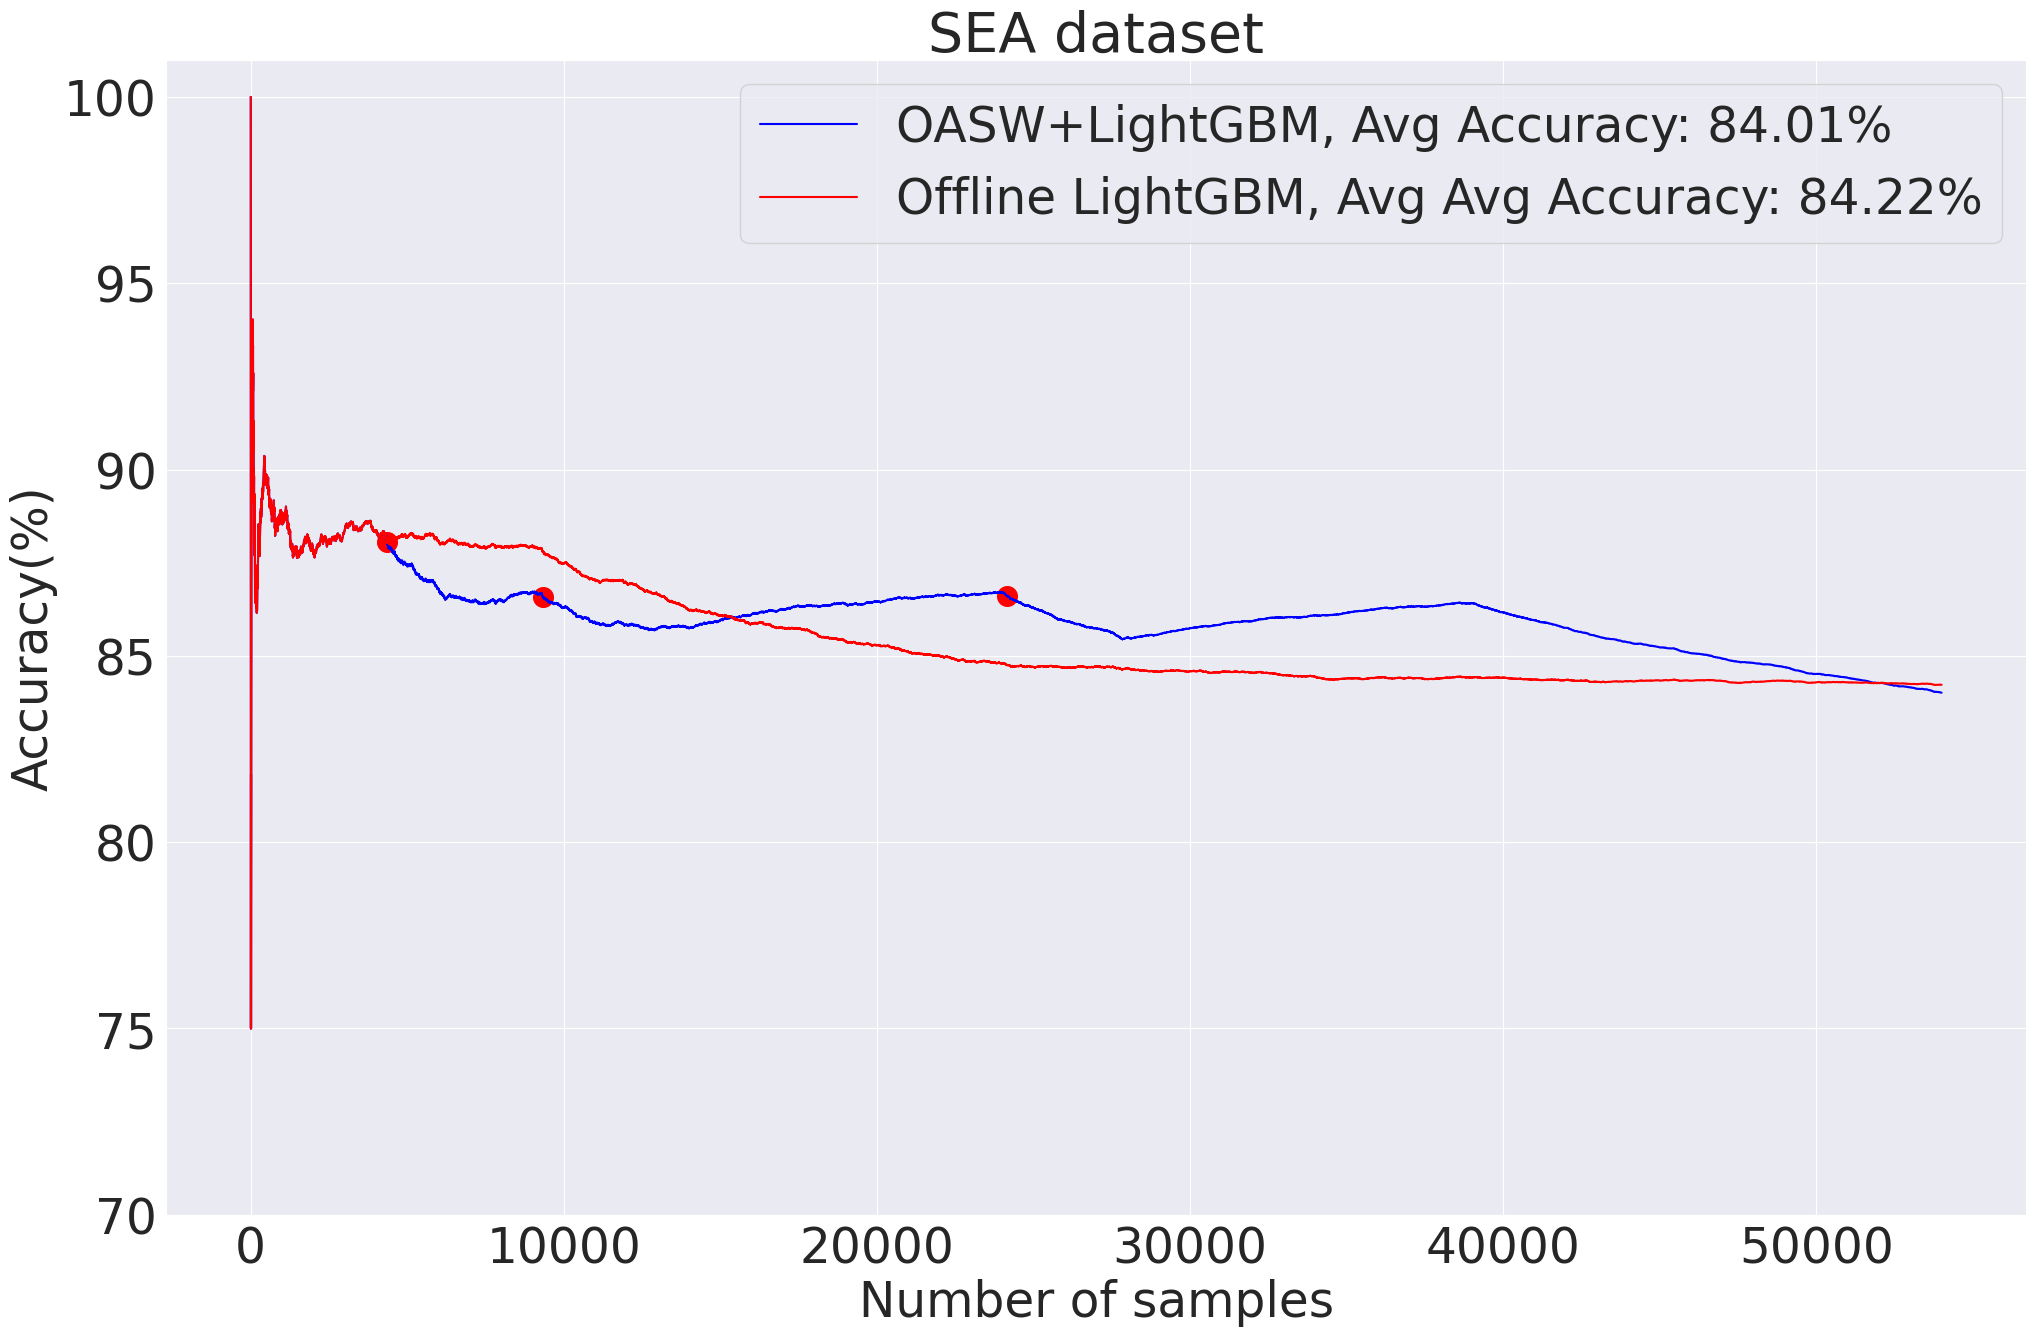

In [18]:
%%time
# Assign the optimal hyperparameters detected by PSO
t1 = time.time()
oasw_plot(a = 0.9844921875, b = 0.956328125, win1 = 752, win2 = 3542)
t2= time.time()
print("time taken: ", t2-t1)

In [19]:
# Define OASW with a figure
def oasw_plot(a=0.99, b=0.95, win1=200, win2=1000):
    a = round(a, 3)
    b = round(b, 3)
    win1 = round(win1)
    win2 = round(win2)

    metric = metrics.Precision()
    metric2 = metrics.Precision()

    i = 0
    t = []
    yt = []
    yp = []
    m = []
    m2 = []
    x_new=[]
    y_new=[]
    dr=[0]
    d=0
    f=0
    tt=0
    th=0
    xt=[]

    classifier = lgb.LGBMClassifier() # Train the initial LightGBM model
    classifier.fit(X_train,y_train)

    classifier2 = lgb.LGBMClassifier() # Train an offline LightGBM model as a comparison model
    classifier2.fit(X_train,y_train)

    for xi, yi in stream.iter_pandas(X_test, y_test):

        xi2=np.array(list(xi.values()))
        y_pred = classifier.predict(xi2.reshape(1, -1))      # make a prediction
        metric = metric.update(yi, int(y_pred[0]))  # update the metric

        y_pred2= classifier2.predict(xi2.reshape(1, -1))
        metric2 = metric2.update(yi, int(y_pred2[0]))

        # Store the y_test, y_pred, x_test, and real-time accuracy
        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        m2.append(metric2.get()*100)
        xt.append(xi2)

        # Monitor the accuracy changes in the sliding window
        if i>2*win1:
            acc1=accuracy_score(yt[i-win1:],yp[i-win1:]) # Current window accuracy
            acc2=accuracy_score(yt[i-2*win1:i-win1],yp[i-2*win1:i-win1]) # Last window accuracy
            if (d==0)&(acc1<a*acc2): # If the window accuracy drops to the warning level
                x_new.append(xi2)
                y_new.append(yi)
                d=1
            if d==1: # In the warning level
                tt=len(y_new)
                if acc1<b*acc2: # If the window accuracy drops to the drift level
                    dr.append(i)# Record the drift start point
                    f=i
                    if tt<win1: # if enough new concept samples are collected
                        classifier.fit(xt[i-win1:],yt[i-win1:])
                    else:
                        classifier.fit(x_new,y_new)
                    d=2
                elif (acc1>a*acc2)|(tt==win2): # If the window accuracy increases back to the normal level (false alarm)
                    x_new=[]
                    y_new=[]
                    d=0
                else:
                    x_new.append(xi2)
                    y_new.append(yi)

            if d==2: # In the drift level
                tt=len(y_new)
                acc3=accuracy_score(yt[f:f+win1],yp[f:f+win1])
                x_new.append(xi2)
                y_new.append(yi)
                if tt>=win1:
                    if (acc1<a*acc3): # When new concept accuracy drops to the warning level
                        if th==0:
                            classifier.fit(x_new,y_new) # Retrain the classifier on all the newly collected samples to obtain a robust classifier
                            th=1
                    if (th==1)&(tt==win2): # When sufficient new concept samples are collected
                        classifier.fit(x_new,y_new) #obtain a robust classifier
                        x_new=[]
                        y_new=[]
                        d=0 # Go back to the normal state for next potential drift detection
                        th=0

        i=i+1

    # Plot the accuracy change figure
    plt.rcParams.update({'font.size': 35})
    plt.ion()
    plt.figure(1,figsize=(24,15))
    sns.set_style("darkgrid")
    plt.clf()
    plt.plot(t,m,'-b',label='OASW+LightGBM, Avg Precision: %.2f%%'%(metric.get()*100))
    plt.plot(t,m2,'red',label='Offline LightGBM, Avg Avg Precision: %.2f%%'%(metric2.get()*100))

    #Plot the drift points
    for i in range(len(dr)):
        if i!=0:
            plt.scatter(dr[i],m[dr[i]],s=200,c='r')

    plt.legend(loc='best')
    plt.ylim(70, 101)
    plt.title('SEA dataset', fontsize=40)
    plt.xlabel('Number of samples')
    plt.ylabel('Precision(%)')

    plt.draw()

[LightGBM] [Info] Number of positive: 3880, number of negative: 2120
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.646667 -> initscore=0.604419
[LightGBM] [Info] Start training from score 0.604419
[LightGBM] [Info] Number of positive: 3880, number of negative: 2120
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.646667 -> initscore=0.604419
[LightGBM] [Info] Start training from score 0.604419
[LightGBM] [Info] Number o

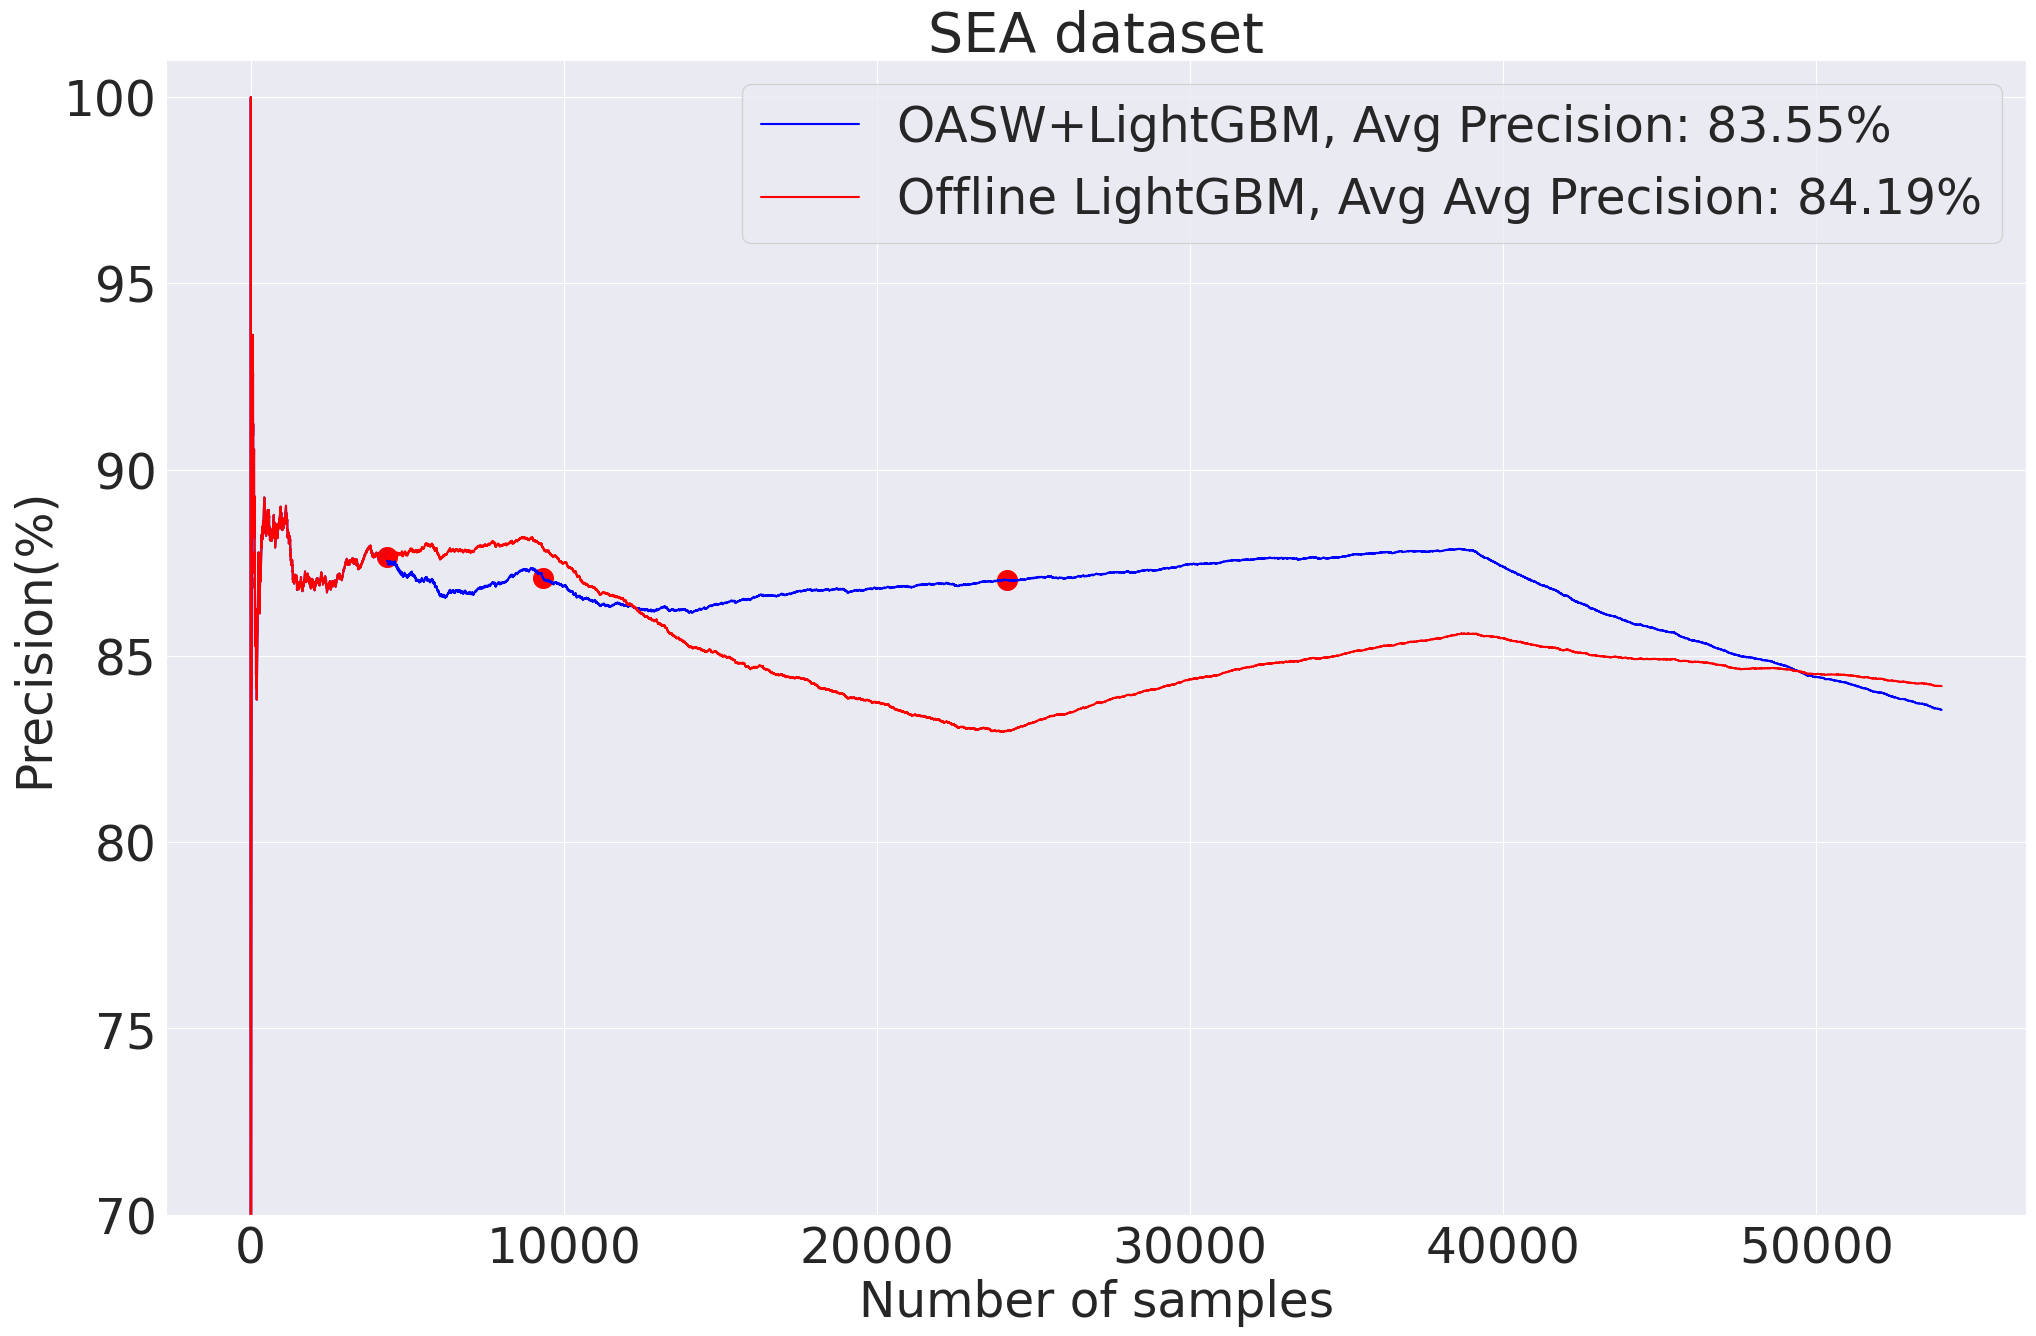

In [20]:
# Assign the optimal hyperparameters detected by PSO
# Assign the optimal hyperparameters detected by PSO
t1 = time.time()
oasw_plot(a = 0.9844921875, b = 0.956328125, win1 = 752, win2 = 3542)
t2= time.time()
print("time taken: ", t2-t1)

In [21]:
# Define OASW with a figure
def oasw_plot(a=0.99, b=0.95, win1=200, win2=1000):
    a = round(a, 3)
    b = round(b, 3)
    win1 = round(win1)
    win2 = round(win2)

    metric = metrics.Recall()
    metric2 = metrics.Recall()

    i = 0
    t = []
    yt = []
    yp = []
    m = []
    m2 = []
    x_new=[]
    y_new=[]
    dr=[0]
    d=0
    f=0
    tt=0
    th=0
    xt=[]

    classifier = lgb.LGBMClassifier() # Train the initial LightGBM model
    classifier.fit(X_train,y_train)

    classifier2 = lgb.LGBMClassifier() # Train an offline LightGBM model as a comparison model
    classifier2.fit(X_train,y_train)

    for xi, yi in stream.iter_pandas(X_test, y_test):

        xi2=np.array(list(xi.values()))
        y_pred = classifier.predict(xi2.reshape(1, -1))      # make a prediction
        metric = metric.update(yi, int(y_pred[0]))  # update the metric

        y_pred2= classifier2.predict(xi2.reshape(1, -1))
        metric2 = metric2.update(yi, int(y_pred2[0]))

        # Store the y_test, y_pred, x_test, and real-time accuracy
        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        m2.append(metric2.get()*100)
        xt.append(xi2)

        # Monitor the accuracy changes in the sliding window
        if i>2*win1:
            acc1=accuracy_score(yt[i-win1:],yp[i-win1:]) # Current window accuracy
            acc2=accuracy_score(yt[i-2*win1:i-win1],yp[i-2*win1:i-win1]) # Last window accuracy
            if (d==0)&(acc1<a*acc2): # If the window accuracy drops to the warning level
                x_new.append(xi2)
                y_new.append(yi)
                d=1
            if d==1: # In the warning level
                tt=len(y_new)
                if acc1<b*acc2: # If the window accuracy drops to the drift level
                    dr.append(i)# Record the drift start point
                    f=i
                    if tt<win1: # if enough new concept samples are collected
                        classifier.fit(xt[i-win1:],yt[i-win1:])
                    else:
                        classifier.fit(x_new,y_new)
                    d=2
                elif (acc1>a*acc2)|(tt==win2): # If the window accuracy increases back to the normal level (false alarm)
                    x_new=[]
                    y_new=[]
                    d=0
                else:
                    x_new.append(xi2)
                    y_new.append(yi)

            if d==2: # In the drift level
                tt=len(y_new)
                acc3=accuracy_score(yt[f:f+win1],yp[f:f+win1])
                x_new.append(xi2)
                y_new.append(yi)
                if tt>=win1:
                    if (acc1<a*acc3): # When new concept accuracy drops to the warning level
                        if th==0:
                            classifier.fit(x_new,y_new) # Retrain the classifier on all the newly collected samples to obtain a robust classifier
                            th=1
                    if (th==1)&(tt==win2): # When sufficient new concept samples are collected
                        classifier.fit(x_new,y_new) #obtain a robust classifier
                        x_new=[]
                        y_new=[]
                        d=0 # Go back to the normal state for next potential drift detection
                        th=0

        i=i+1

    # Plot the accuracy change figure
    plt.rcParams.update({'font.size': 35})
    plt.ion()
    plt.figure(1,figsize=(24,15))
    sns.set_style("darkgrid")
    plt.clf()
    plt.plot(t,m,'-b',label='OASW+LightGBM, Avg Recall: %.2f%%'%(metric.get()*100))
    plt.plot(t,m2,'red',label='Offline LightGBM, Avg Avg Recall: %.2f%%'%(metric2.get()*100))

    #Plot the drift points
    for i in range(len(dr)):
        if i!=0:
            plt.scatter(dr[i],m[dr[i]],s=200,c='r')

    plt.legend(loc='best')
    plt.ylim(70, 101)
    plt.title('SEA dataset', fontsize=40)
    plt.xlabel('Number of samples')
    plt.ylabel('Recall(%)')

    plt.draw()

[LightGBM] [Info] Number of positive: 3880, number of negative: 2120
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.646667 -> initscore=0.604419
[LightGBM] [Info] Start training from score 0.604419
[LightGBM] [Info] Number of positive: 3880, number of negative: 2120
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.646667 -> initscore=0.604419
[LightGBM] [Info] Start training from score 0.604419
[LightGBM] [Info] Number o

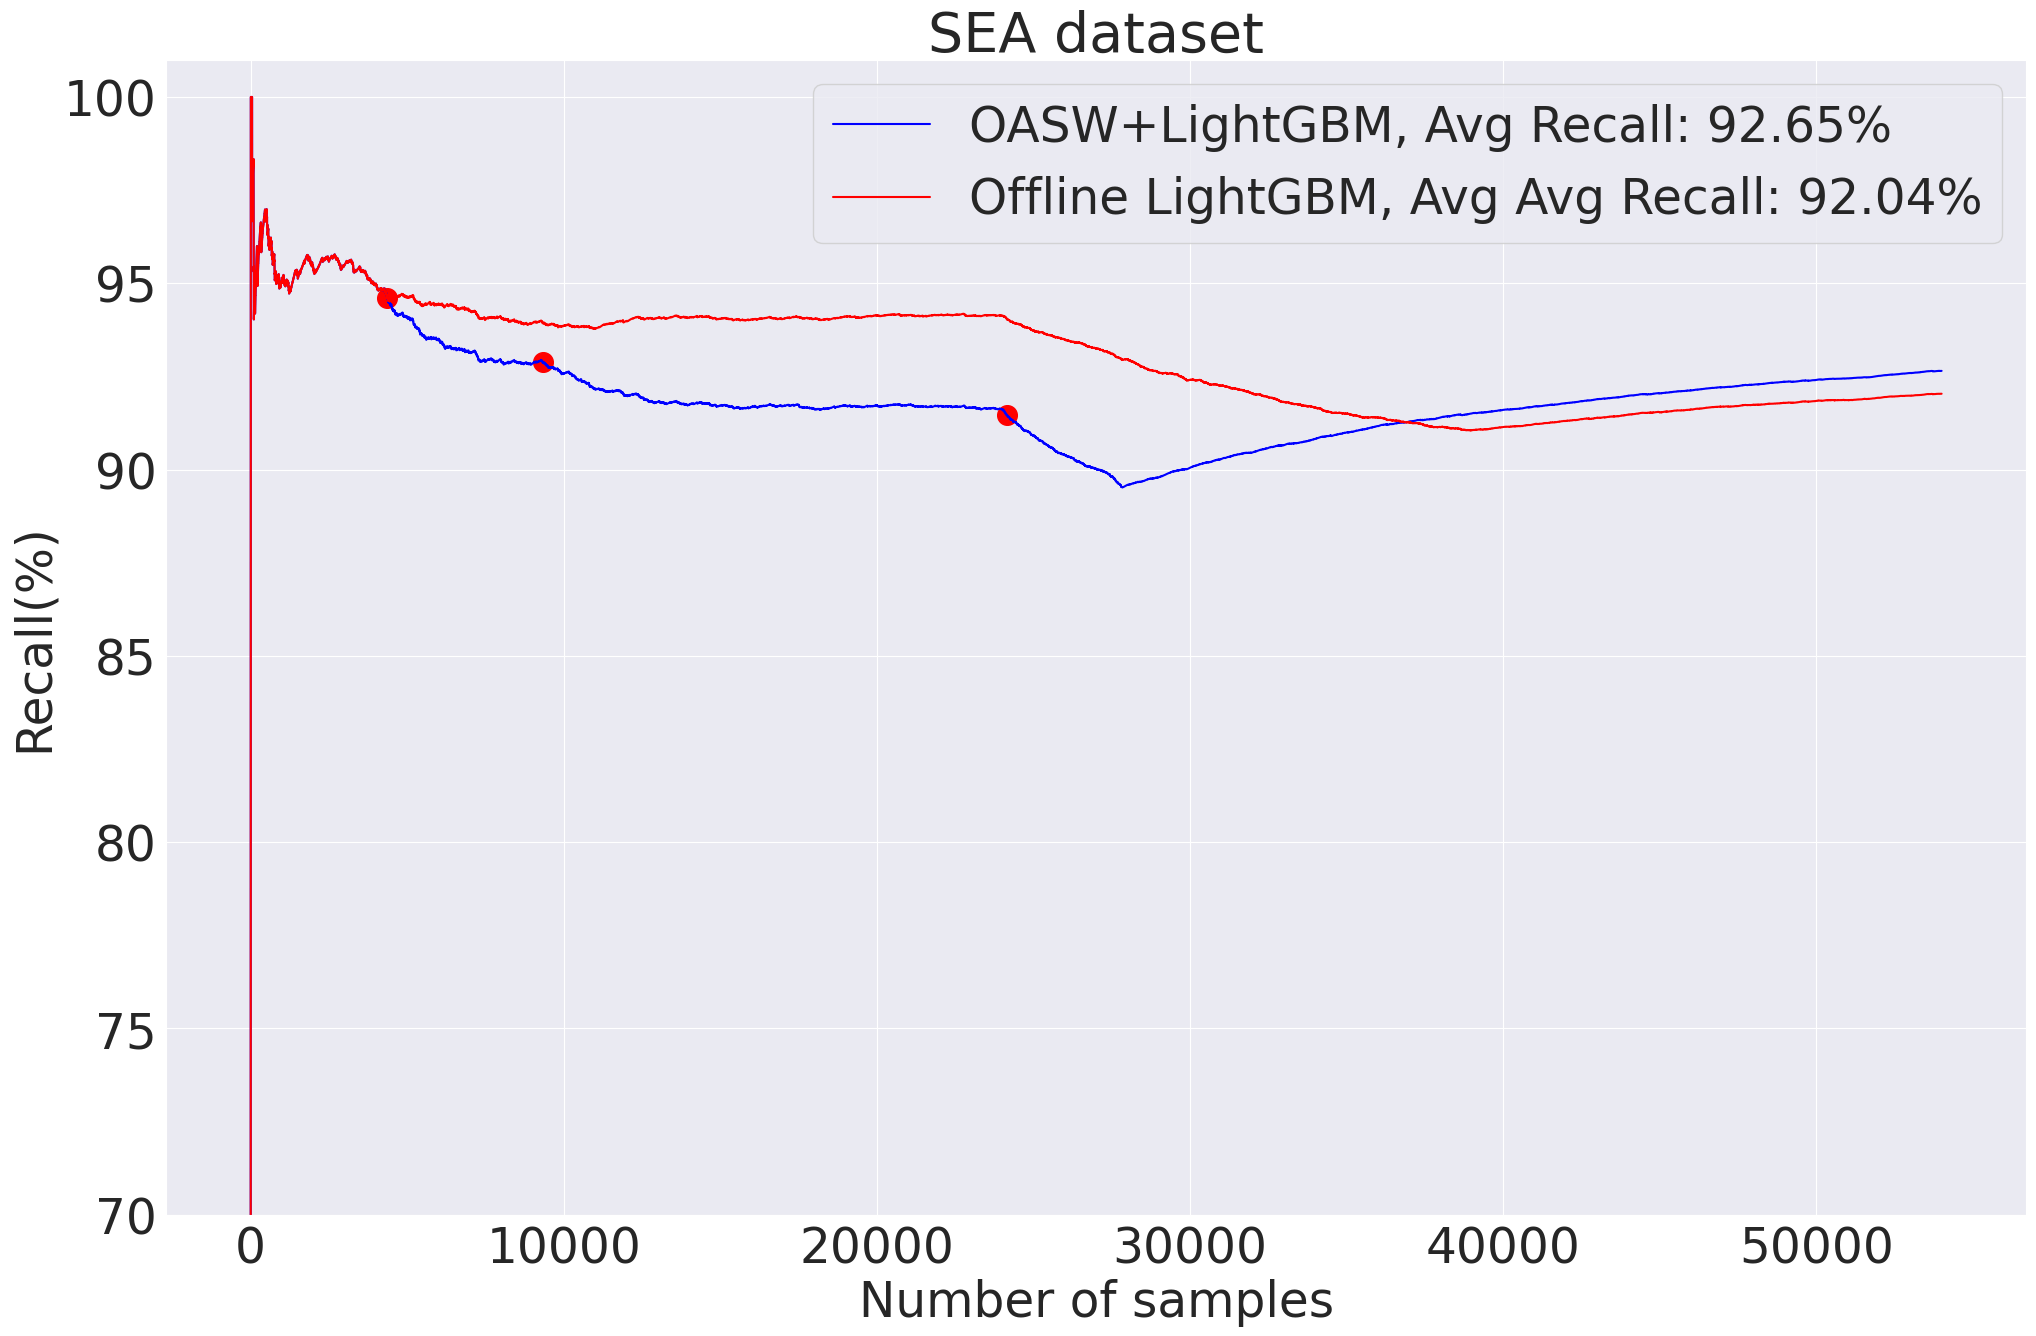

In [22]:
# Assign the optimal hyperparameters detected by PSO
t1 = time.time()
oasw_plot(a = 0.9844921875, b = 0.956328125, win1 = 752, win2 = 3542)
t2= time.time()
print("time taken: ", t2-t1)

In [23]:
# Define OASW with a figure
def oasw_plot(a=0.99, b=0.95, win1=200, win2=1000):
    a = round(a, 3)
    b = round(b, 3)
    win1 = round(win1)
    win2 = round(win2)

    metric = metrics.F1()
    metric2 = metrics.F1()

    i = 0
    t = []
    yt = []
    yp = []
    m = []
    m2 = []
    x_new=[]
    y_new=[]
    dr=[0]
    d=0
    f=0
    tt=0
    th=0
    xt=[]

    classifier = lgb.LGBMClassifier() # Train the initial LightGBM model
    classifier.fit(X_train,y_train)

    classifier2 = lgb.LGBMClassifier() # Train an offline LightGBM model as a comparison model
    classifier2.fit(X_train,y_train)

    for xi, yi in stream.iter_pandas(X_test, y_test):

        xi2=np.array(list(xi.values()))
        y_pred = classifier.predict(xi2.reshape(1, -1))      # make a prediction
        metric = metric.update(yi, int(y_pred[0]))  # update the metric

        y_pred2= classifier2.predict(xi2.reshape(1, -1))
        metric2 = metric2.update(yi, int(y_pred2[0]))

        # Store the y_test, y_pred, x_test, and real-time accuracy
        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        m2.append(metric2.get()*100)
        xt.append(xi2)

        # Monitor the accuracy changes in the sliding window
        if i>2*win1:
            acc1=accuracy_score(yt[i-win1:],yp[i-win1:]) # Current window accuracy
            acc2=accuracy_score(yt[i-2*win1:i-win1],yp[i-2*win1:i-win1]) # Last window accuracy
            if (d==0)&(acc1<a*acc2): # If the window accuracy drops to the warning level
                x_new.append(xi2)
                y_new.append(yi)
                d=1
            if d==1: # In the warning level
                tt=len(y_new)
                if acc1<b*acc2: # If the window accuracy drops to the drift level
                    dr.append(i)# Record the drift start point
                    f=i
                    if tt<win1: # if enough new concept samples are collected
                        classifier.fit(xt[i-win1:],yt[i-win1:])
                    else:
                        classifier.fit(x_new,y_new)
                    d=2
                elif (acc1>a*acc2)|(tt==win2): # If the window accuracy increases back to the normal level (false alarm)
                    x_new=[]
                    y_new=[]
                    d=0
                else:
                    x_new.append(xi2)
                    y_new.append(yi)

            if d==2: # In the drift level
                tt=len(y_new)
                acc3=accuracy_score(yt[f:f+win1],yp[f:f+win1])
                x_new.append(xi2)
                y_new.append(yi)
                if tt>=win1:
                    if (acc1<a*acc3): # When new concept accuracy drops to the warning level
                        if th==0:
                            classifier.fit(x_new,y_new) # Retrain the classifier on all the newly collected samples to obtain a robust classifier
                            th=1
                    if (th==1)&(tt==win2): # When sufficient new concept samples are collected
                        classifier.fit(x_new,y_new) #obtain a robust classifier
                        x_new=[]
                        y_new=[]
                        d=0 # Go back to the normal state for next potential drift detection
                        th=0

        i=i+1

    # Plot the accuracy change figure
    plt.rcParams.update({'font.size': 35})
    plt.ion()
    plt.figure(1,figsize=(24,15))
    sns.set_style("darkgrid")
    plt.clf()
    plt.plot(t,m,'-b',label='OASW+LightGBM, Avg F1-Score: %.2f%%'%(metric.get()*100))
    plt.plot(t,m2,'red',label='Offline LightGBM, Avg Avg F1-Score: %.2f%%'%(metric2.get()*100))

    #Plot the drift points
    for i in range(len(dr)):
        if i!=0:
            plt.scatter(dr[i],m[dr[i]],s=200,c='r')

    plt.legend(loc='best')
    plt.ylim(70, 101)
    plt.title('SEA dataset', fontsize=40)
    plt.xlabel('Number of samples')
    plt.ylabel('F1-Score(%)')

    plt.draw()

[LightGBM] [Info] Number of positive: 3880, number of negative: 2120
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.646667 -> initscore=0.604419
[LightGBM] [Info] Start training from score 0.604419
[LightGBM] [Info] Number of positive: 3880, number of negative: 2120
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.646667 -> initscore=0.604419
[LightGBM] [Info] Start training from score 0.604419
[LightGBM] [Info] Number o

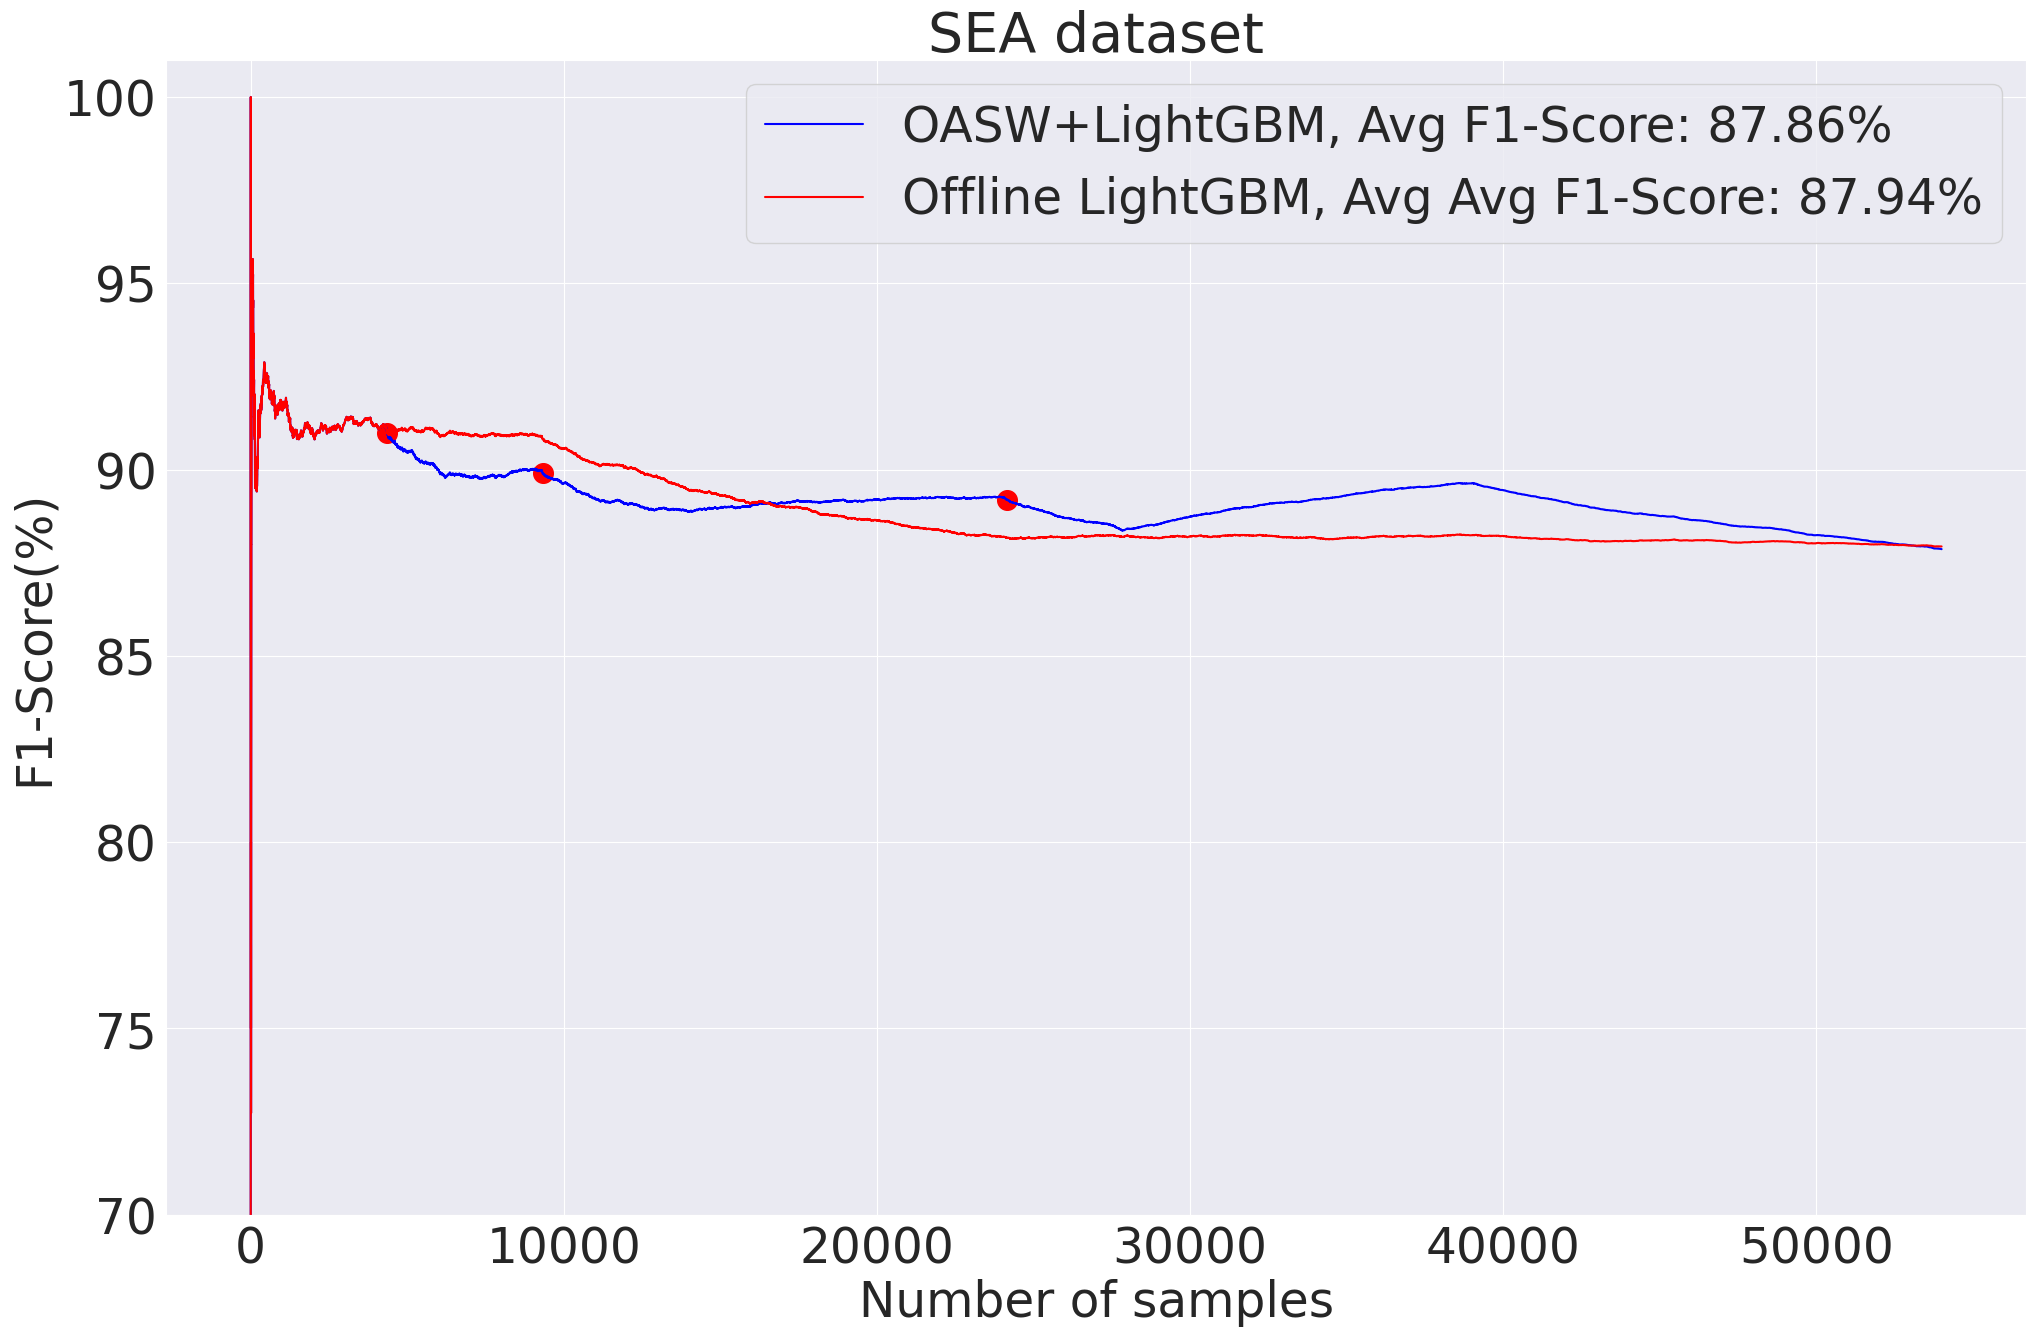

In [24]:
# Assign the optimal hyperparameters detected by PSO
t1 = time.time()
oasw_plot(a = 0.9844921875, b = 0.956328125, win1 = 752, win2 = 3542)
t2= time.time()
print("time taken: ", t2-t1)